# 데이터 분할

In [132]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import optuna
from math import sqrt
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [133]:
# 파일 경로
file_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\서울대공원_날씨_미세먼지_입장객_병합.xlsx"

# 엑셀 파일 불러오기
df = pd.read_excel(file_path)

# 날짜 형식 변환 및 정렬
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [134]:
df

,date,tmin,tmax,rain,snow,wind,humidity,air,visitors_total,lag_1,lag_7,rolling_7,day_of_week,month,year,vacation,weekend
0,2022-01-08,-5.0,3.7,0.0,0.0,3.5,64.3,44,1431,463,1043,714.428571,5,1,2022,1,1
1,2022-01-09,-1.2,5.6,0.0,0.0,2.8,71.5,121,1116,1431,1084,719.000000,6,1,2022,1,1
2,2022-01-10,-3.4,4.4,0.9,0.9,3.4,68.3,74,367,1116,324,725.142857,0,1,2022,1,0
3,2022-01-11,-10.3,0.3,0.2,1.0,7.2,55.5,43,249,367,417,701.142857,1,1,2022,1,0
4,2022-01-12,-11.3,-3.4,0.0,0.2,4.2,47.8,31,139,249,349,671.142857,2,1,2022,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,2024-12-27,-5.9,1.8,0.0,0.0,5.8,51.4,28,709,424,293,682.142857,4,12,2024,0,0
1085,2024-12-28,-6.7,1.1,0.0,0.0,5.8,48.3,28,715,709,583,701.000000,5,12,2024,0,1
1086,2024-12-29,-4.2,6.1,0.0,0.0,2.8,56.1,23,1156,715,599,780.571429,6,12,2024,0,1
1087,2024-12-30,1.9,10.1,0.0,0.0,6.9,68.5,49,19266,1156,360,3481.428571,0,12,2024,0,0


In [135]:
# 데이터 분할
train_df = df[df['date'] < "2024-01-01"]
val_df = df[(df['date'] >= "2024-01-01") & (df['date'] <= "2024-06-30")]
test_df = df[df['date'] > "2024-06-30"]

# 확인
print(f"Train: {train_df['date'].min().date()} ~ {train_df['date'].max().date()} ({len(train_df)}일)")
print(f"Validation: {val_df['date'].min().date()} ~ {val_df['date'].max().date()} ({len(val_df)}일)")
print(f"Test: {test_df['date'].min().date()} ~ {test_df['date'].max().date()} ({len(test_df)}일)")

Train: 2022-01-08 ~ 2023-12-31 (723일)
Validation: 2024-01-01 ~ 2024-06-30 (182일)
Test: 2024-07-01 ~ 2024-12-31 (184일)


# 베이스라인 모델

### Naïve, Seasonal Naïve

In [136]:
# 전날 값(Naive), 7일 전 값(Seasonal Naive)을 예측값으로 사용
val_df = val_df.copy()
test_df = test_df.copy()

# Naïve 예측값 생성
val_df['naive_pred'] = train_df['visitors_total'].tolist()[-1:] + val_df['visitors_total'].tolist()[:-1]
test_df['naive_pred'] = val_df['visitors_total'].tolist()[-1:] + test_df['visitors_total'].tolist()[:-1]

# Seasonal Naïve 예측값 생성
val_df['seasonal_naive_pred'] = [None]*7 + val_df['visitors_total'].tolist()[:-7]
test_df['seasonal_naive_pred'] = val_df['visitors_total'].tolist()[-7:] + test_df['visitors_total'].tolist()[:-7]

In [137]:
# 성능 지표 계산 함수
def evaluate_model(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE 계산 시 y_true = 0인 경우 제외
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} 성능:")
    print(f" - RMSE : {rmse:.2f}")
    print(f" - MAE  : {mae:.2f}")
    print(f" - MAPE : {mape:.2f}%")
    print(f" - R²   : {r2:.3f}")
    print()

In [138]:
# Naïve
evaluate_model(test_df['visitors_total'][1:], test_df['naive_pred'][1:], model_name="Naïve")

# Seasonal Naïve
evaluate_model(test_df['visitors_total'][7:], test_df['seasonal_naive_pred'][7:], model_name="Seasonal Naïve")

Naïve 성능:
 - RMSE : 6046.60
 - MAE  : 3185.57
 - MAPE : 186.44%
 - R²   : -0.250

Seasonal Naïve 성능:
 - RMSE : 5228.03
 - MAE  : 2656.84
 - MAPE : 118.21%
 - R²   : 0.089



# 비교 모델

### XGBoost, RandomForestRegressor

In [139]:
# 특성과 타깃 분리
features = df.columns.drop(['date', 'visitors_total'])
target = 'visitors_total'

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

In [140]:
# Optuna objective 함수
def objective(trial, model_type='rf'):
    if model_type == 'rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        }
        model = RandomForestRegressor(**params, random_state=42)

    elif model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params, random_state=42, verbosity=0)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return sqrt(mean_squared_error(y_val, y_pred))

In [141]:
# XGBoost 튜닝 및 평가
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(lambda trial: objective(trial, model_type='xgb'), n_trials=30)

xgb_model = XGBRegressor(**xgb_study.best_params, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
evaluate_model(y_test, xgb_pred, model_name="XGBoost")


# RandomForest 튜닝 및 평가
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(lambda trial: objective(trial, model_type='rf'), n_trials=30)

rf_model = RandomForestRegressor(**rf_study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
evaluate_model(y_test, rf_pred, model_name="RandomForest")

[I 2025-06-16 04:56:37,390] A new study created in memory with name: no-name-35e22258-a7bf-4fdc-9d73-02064cf80f7c
[I 2025-06-16 04:56:37,431] Trial 0 finished with value: 4016.935896924421 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.23201032180184372, 'subsample': 0.5395828196497816, 'colsample_bytree': 0.6844294999472694}. Best is trial 0 with value: 4016.935896924421.
[I 2025-06-16 04:56:37,667] Trial 1 finished with value: 5797.990686436121 and parameters: {'n_estimators': 174, 'max_depth': 10, 'learning_rate': 0.23290954756178503, 'subsample': 0.8861247919270896, 'colsample_bytree': 0.9895361907291151}. Best is trial 0 with value: 4016.935896924421.
[I 2025-06-16 04:56:37,777] Trial 2 finished with value: 4457.137197798605 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.19910144348164246, 'subsample': 0.8466989580338693, 'colsample_bytree': 0.937378901589851}. Best is trial 0 with value: 4016.935896924421.
[I 2025-06-16 04:56:37

XGBoost 성능:
 - RMSE : 3387.67
 - MAE  : 1781.62
 - MAPE : 87.09%
 - R²   : 0.606



[I 2025-06-16 04:56:42,838] Trial 0 finished with value: 4055.2158294542205 and parameters: {'n_estimators': 106, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 4055.2158294542205.
[I 2025-06-16 04:56:42,914] Trial 1 finished with value: 4579.120225406419 and parameters: {'n_estimators': 107, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 4055.2158294542205.
[I 2025-06-16 04:56:43,758] Trial 2 finished with value: 3996.5479886279677 and parameters: {'n_estimators': 297, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 3996.5479886279677.
[I 2025-06-16 04:56:43,940] Trial 3 finished with value: 4589.062548362252 and parameters: {'n_estimators': 266, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 3996.5479886279677.
[I 

RandomForest 성능:
 - RMSE : 3410.50
 - MAE  : 1672.95
 - MAPE : 88.81%
 - R²   : 0.601



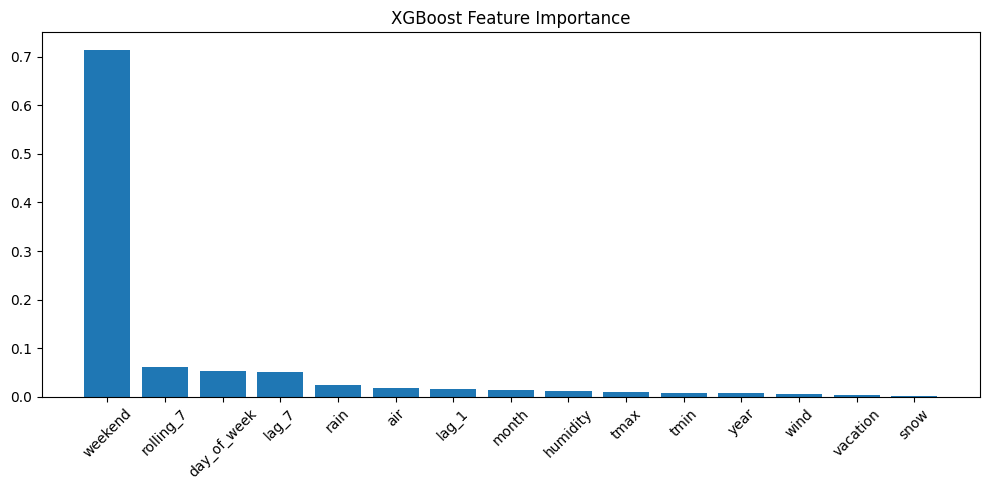

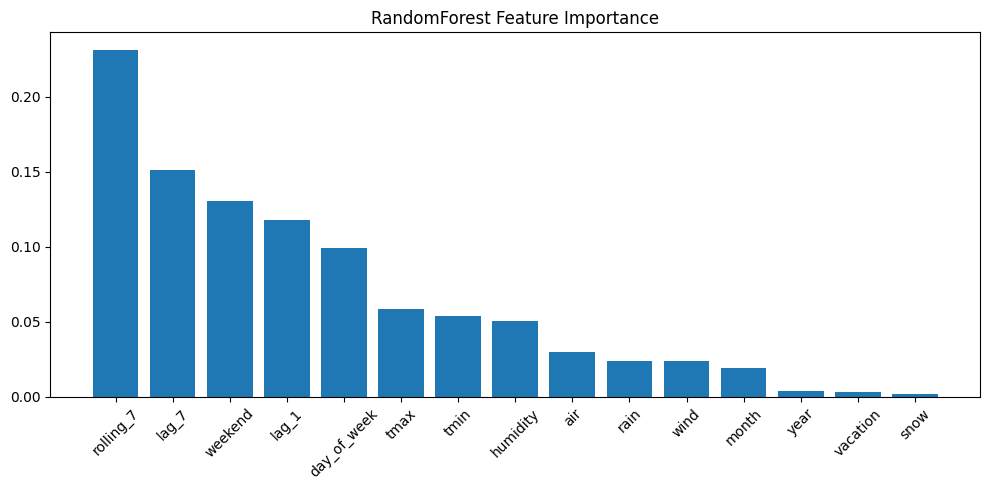

In [142]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features_sorted = [features[i] for i in indices]

    plt.figure(figsize=(10, 5))
    plt.title(f"{model_name} Feature Importance")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), features_sorted, rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_model, "XGBoost")
plot_feature_importance(rf_model, "RandomForest")